In [1]:
from pathinit import *

import numpy as np


import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
jax.config.update("jax_enable_x64", True)

import numpyro
from numpyro import optim
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import MCMC, HMC, NUTS, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoBNAFNormal, AutoMultivariateNormal
from numpyro.infer.reparam import NeuTraReparam
from numpyro.handlers import seed, trace, condition

import matplotlib as mpl
from matplotlib import pyplot as plt

import corner
import arviz as az
mpl.rcParams['font.size'] = 20

2022-04-12 16:53:42.695076: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-04-12 16:53:48.082372: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-04-12 16:53:48.253562: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 


In [2]:
def plot_params_kde(samples,hdi_probs=[0.393, 0.865, 0.989], 
                    patName=None, fname=None, pcut=None,
                   var_names=None, point_estimate="median"):
    
    if pcut is not None:
        low = pcut[0]
        up  = pcut[1] 
        #keep only data in the [low, up] percentiles ex. 0.5, 99.5
        samples={name:value[(value>np.percentile(value,low)) &  (value<np.percentile(value,up))] \
          for name, value in samples.items()}
        len_min = np.min([len(value) for name, value in samples.items()])
        len_max = np.max([len(value) for name, value in samples.items()])
        if (len_max-len_min)>0.01*len_max:
            print(f"Warning: pcut leads to min/max spls size = {len_min}/{len_max}")
        samples = {name:value[:len_min] for name, value in samples.items()}
    
    axs= az.plot_pair(
            samples,
            var_names=var_names,
            figsize=(10,10),
            kind="kde",
    #        marginal_kwargs={"plot_kwargs": {"lw": 3, "c": "b"}},
            kde_kwargs={
#                "hdi_probs": [0.68, 0.9],  # Plot 68% and 90% HDI contours
                "hdi_probs":hdi_probs,  # 1, 2 and 3 sigma contours
                "contour_kwargs":{"colors":('r', 'green', 'blue'), "linewidths":3},
                "contourf_kwargs":{"alpha":0},
            },
            point_estimate_kwargs={"lw": 3, "c": "b"},
            marginals=True, textsize=20, point_estimate=point_estimate,
        );
    
    plt.tight_layout()
    
    if patName is not None:
        patName_patch = mpatches.Patch(color='b', label=patName)
        axs[0,0].legend(handles=[patName_patch], fontsize=40, bbox_to_anchor=(1, 0.7));
    if fname is not None:
        plt.savefig(fname)
        plt.close()

In [3]:
def mean_fn(x, params):
    """Parametrisation avant et apres RT (t=0) """
    R0 = params["R0"]
    v  = params["v"]
    k  = params["k"]
    tau =  params["tau"]
    return jnp.piecewise(
        x, [x < 0, x >= 0],
        [lambda x: R0 + v*x, 
         lambda x: R0 + v*x - k*(1.-jnp.exp(-x/tau))
        ])

In [4]:
def model(t,Robs=None,
          R0_min=10.,v_min = 0.5,k_min = 1., tau_min=0.1,
          R0_max=50.,v_max = 3.5,k_max = 10., tau_max=5.0,
          sigma= 1.0):

    R0 = numpyro.sample('R0', dist.Uniform(R0_min,R0_max))
    v  = numpyro.sample('v', dist.Uniform(v_min,v_max))
    k  = numpyro.sample('k', dist.Uniform(k_min,k_max))
    tau= numpyro.sample('tau', dist.Uniform(tau_min,tau_max))

    
    params = {"R0":R0,"v":v,"k":k,"tau":tau}
    mu = mean_fn(t,params)
    
    return numpyro.sample('R', dist.Normal(mu, sigma), obs=Robs)

In [5]:
rng_key = jax.random.PRNGKey(42)
rng_key, rng_key0, rng_key1, rng_key2 = jax.random.split(rng_key, 4)

2022-04-12 16:54:48.682203: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-04-12 16:54:48.682269: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
rng_key, rng_key0, rng_key1, rng_key2

(DeviceArray([2954079971, 2575172198], dtype=uint32),
 DeviceArray([1139032965, 1035738655], dtype=uint32),
 DeviceArray([3276725750, 1223413151], dtype=uint32),
 DeviceArray([173471767,  13772463], dtype=uint32))

In [7]:
tMes = jax.random.uniform(rng_key0,minval=-5.,maxval=5.0,shape=(20,))
tMes=jnp.append(tMes,0.0)
tMes=jnp.sort(tMes)

In [8]:
par_true={"R0":35.0, "v":2.20, "k":15.5, "tau": 1.0}
sigma_obs=1.0

In [9]:
RMes = mean_fn(tMes,par_true) + sigma_obs * jax.random.normal(rng_key1,shape=tMes.shape)

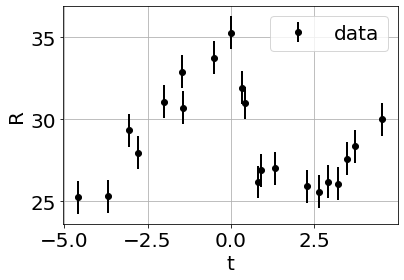

In [10]:
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

In [11]:
# Run NUTS.
kernel = NUTS(model, dense_mass=True, target_accept_prob=0.9,
              init_strategy=numpyro.infer.init_to_median())
num_samples = 5_000
n_chains = 4
mcmc = MCMC(kernel, num_warmup=1_000, num_samples=num_samples,  
            num_chains=n_chains,progress_bar=True)
mcmc.run(rng_key, t=tMes, Robs=RMes,sigma=sigma_obs, k_max = 20.)
mcmc.print_summary()
samples_nuts = mcmc.get_samples()

/tmp/ipykernel_151/4224659807.py:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1_000, num_samples=num_samples,
  0%|          | 0/6000 [00:00<?, ?it/s]/sps/lsst/users/campagne/anaconda3/envs/JaxTutos/lib/python3.8/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|██████████| 6000/6000 [00:07<00:00, 810.24it/s, 7 steps of size 2.84e-01. acc. prob=0.97] 
/sps/lsst/users/campagne/anaconda3/envs/JaxTutos/lib/python3.8/site-packages/jax/


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        R0     35.32      0.55     35.32     34.44     36.24   6499.95      1.00
         k     16.59      1.34     16.59     14.44     18.87   5080.80      1.00
       tau      0.95      0.11      0.95      0.77      1.14  11046.99      1.00
         v      2.36      0.21      2.36      2.02      2.72   5965.33      1.00

Number of divergences: 0


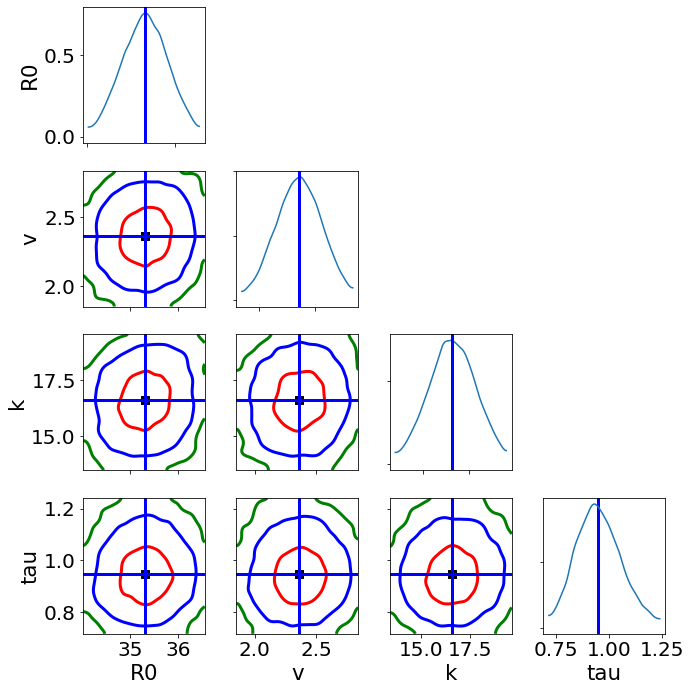

In [12]:
plot_params_kde(samples_nuts, pcut=[1,99], var_names=['R0', 'v','k', 'tau'])

In [13]:
t_val = np.linspace(-5,5,100)

In [14]:
Rtrue_val = mean_fn(t_val,par_true)

In [15]:
func = jax.vmap(lambda x: mean_fn(t_val,x))

In [16]:
Rall_val= func(samples_nuts)

In [17]:
Rmean_val = jnp.mean(Rall_val,axis=0)

In [18]:
std_R_val = jnp.std(Rall_val,axis=0)

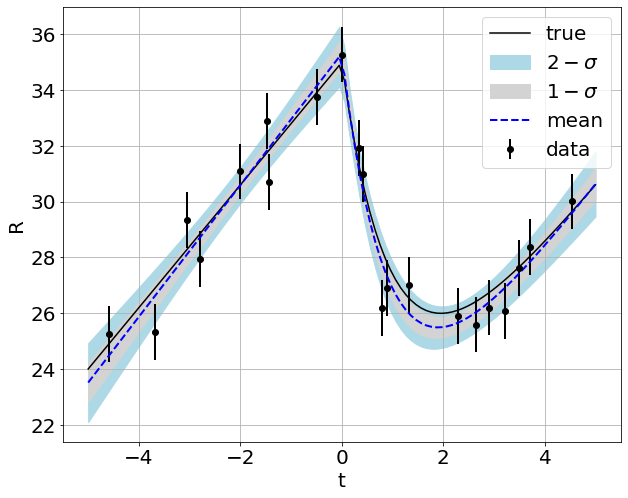

In [19]:
fig=plt.figure(figsize=(10,8))
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.plot(t_val,Rtrue_val,c='k',label="true")

plt.fill_between(t_val, Rmean_val-2*std_R_val, Rmean_val+2*std_R_val, 
                    color="lightblue",label=r"$2-\sigma$")
plt.fill_between(t_val, Rmean_val-std_R_val, Rmean_val+std_R_val, 
                    color="lightgray",label=r"$1-\sigma$")
# plot mean prediction
plt.plot(t_val, Rmean_val, "blue", ls="--", lw=2.0, label="mean")


plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();